<a href="https://colab.research.google.com/github/paddy-03/Sentiment-Analysis-Amazon-Fine-Food-Reviews/blob/master/Amazon_Food_Reviews_(Decision_Trees)_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('./drive/My Drive/amazon_food_reviews')

In [3]:
!pip install numpy==1.16.1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

     |████████████████████████████████| 17.3MB 36.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.17.4
    Uninstalling numpy-1.17.4:
      Successfully uninstalled numpy-1.17.4


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score
from tqdm import tqdm

In [0]:
x_train_cv = np.load('x_train_cv.npy')
x_test_cv =  np.load('x_test_cv.npy')
x_train_tfidf = np.load('x_train_tfidf.npy')
x_test_tfidf = np.load('x_test_tfidf.npy')
x_train_w2v_av = np.load('x_train_w2v_av.npy')
x_test_w2v_av = np.load('x_test_w2v_av.npy')
x_train_w2v_tf = np.load('x_train_w2v_tf.npy')
x_test_w2v_tf = np.load('x_test_w2v_tf.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

In [6]:
np.unique(y_train, return_counts=True)

(array([0., 1.]), array([3772, 3728]))

## BoW approach

In [159]:
depths=[1,5,10,50,100,500,1000]
min_samples=[2,5,10,15,100,500,1000]
parameters=dict(max_depth=depths,min_samples_split=min_samples)
clf=RandomizedSearchCV(tree.DecisionTreeClassifier(),parameters, scoring='roc_auc', refit=True, cv=3,return_train_score=True)

clf.fit(x_train_cv, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=None,
                                                    splitter='best')

In [0]:
cv_error=clf.cv_results_['mean_test_score']
train_error=clf.cv_results_['mean_train_score']
pred=clf.predict(x_train_cv)
score=roc_auc_score(y_train, pred)
split=clf.best_params_['min_samples_split']
depth=clf.best_params_['max_depth']

In [161]:
print("Auc Score: ", score)
print("Best min_samples_split:", split,' ', "Best max_depth:", depth)

Auc Score:  0.7317347669068218
Best min_samples_split: 1000   Best max_depth: 50


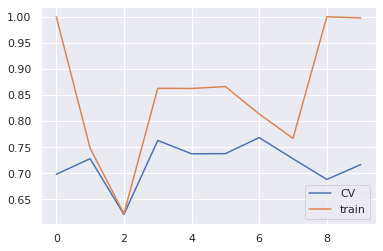

In [179]:
plt.figure(figsize=(6,4))
plt.plot(cv_error, label='CV')
plt.plot(train_error, label='train')
plt.legend()
plt.show()

In [163]:
model_cv=tree.DecisionTreeClassifier(max_depth=depth, min_samples_split=split)
model_cv.fit(x_train_cv, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=1000,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [164]:
w_cv=model.feature_importances_
y_pred_cv = model_cv.predict(x_test_cv)
print("Test accuracy:", accuracy_score(y_test, y_pred_cv))

Test accuracy: 0.7156


In [0]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_cv)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [166]:
df_cm

,negative,positive
negative,828,400
positive,311,961


In [167]:

# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_cv))

              precision    recall  f1-score   support

         0.0       0.73      0.67      0.70      1228
         1.0       0.71      0.76      0.73      1272

    accuracy                           0.72      2500
   macro avg       0.72      0.71      0.71      2500
weighted avg       0.72      0.72      0.72      2500



In [0]:
y_conf_cv = model_cv.predict_proba(x_test_cv)[:,1]
fpr, tpr, threshold = roc_curve(y_test,y_conf_cv,pos_label=1)

In [169]:
roc_auc = auc(fpr, tpr)
roc_auc

0.789940051830455

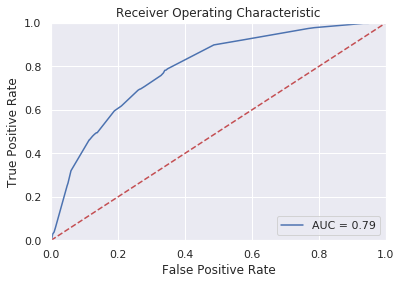

In [180]:
plt.figure(figsize=(6,4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


**Top 10 important features**

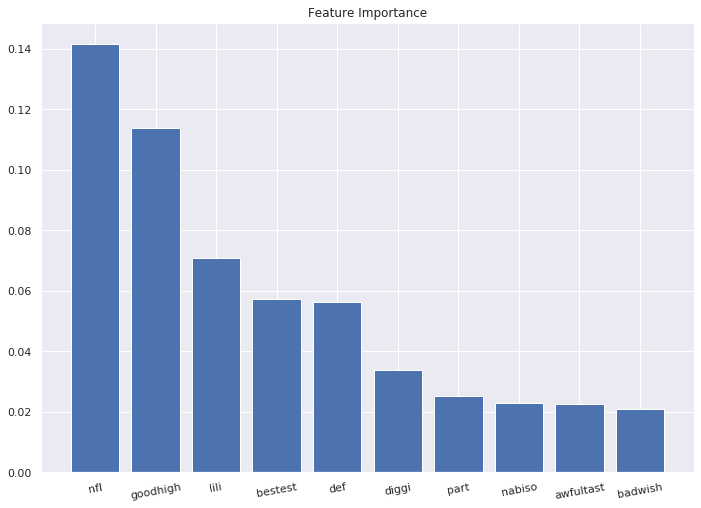

In [196]:
# print('top 10 features for -ve class: \n', df[1].sort_values(ascending=False)[:10])
bow_features=np.load('cv_feature_names.npy')
d = dict(zip(bow_features, w_cv))
# Sort feature importances in descending order
indices = np.argsort(w_cv)[::-1][:10]

# Rearrange feature names so they match the sorted feature importances
# names = uni_gram.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(10), w_cv[indices])

# Add feature names as x-axis labels
names = np.array(bow_features)
plt.xticks(range(10), names[indices], rotation=10)

# Show plot
plt.show()
# uni_gram.get_feature_names()

In [149]:
names[indices]

array(['nfl', 'goodhigh', 'lili', 'bestest', 'def', 'diggi', 'part',
       'nabiso', 'awfultast', 'badwish'], dtype='<U71')

**Graphviz Visualization**

In [172]:
import graphviz
dot_data = tree.export_graphviz(model_cv, out_file=None, feature_names=bow_features) 
graph = graphviz.Source(dot_data) 
graph.render("tree_representation_cv")

'tree_representation_cv.pdf'

## Tf-Idf vectorizer

In [173]:
depths=[1,5,10,50,100,500,1000]
min_samples=[2,5,10,15,100,500,1000]
parameters=dict(max_depth=depths,min_samples_split=min_samples)
clf=RandomizedSearchCV(tree.DecisionTreeClassifier(),parameters, scoring='roc_auc', refit=True, cv=3,return_train_score=True)

clf.fit(x_train_tfidf, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=None,
                                                    splitter='best')

In [0]:
cv_error=clf.cv_results_['mean_test_score']
train_error=clf.cv_results_['mean_train_score']
pred=clf.predict(x_train_tfidf)
score=roc_auc_score(y_train, pred)
split=clf.best_params_['min_samples_split']
depth=clf.best_params_['max_depth']

In [175]:
print("Auc Score: ", score)
print("Best min_samples_split:", split,' ', "Best max_depth:", depth)

Auc Score:  0.7510804994106108
Best min_samples_split: 1000   Best max_depth: 500


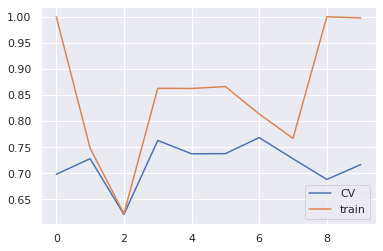

In [181]:
plt.figure(figsize=(6,4))
plt.plot(cv_error, label='CV')
plt.plot(train_error, label='train')
plt.legend()
plt.show()

In [183]:
model_tfidf=tree.DecisionTreeClassifier(max_depth=depth, min_samples_split=split)
model_tfidf.fit(x_train_tfidf, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=500,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=1000,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [185]:
w_tfidf=model_tfidf.feature_importances_
y_pred_tfidf = model_tfidf.predict(x_test_tfidf)
print("Test accuracy:", accuracy_score(y_test, y_pred_tfidf))

Test accuracy: 0.7224


In [0]:
# plot confusion matrix to describe the performance of classifier.
plt.figure(figsize=(6,4))
import seaborn as sns
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tfidf)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [187]:
df_cm

,negative,positive
negative,808,420
positive,274,998


In [189]:

# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_tfidf))

              precision    recall  f1-score   support

         0.0       0.75      0.66      0.70      1228
         1.0       0.70      0.78      0.74      1272

    accuracy                           0.72      2500
   macro avg       0.73      0.72      0.72      2500
weighted avg       0.72      0.72      0.72      2500



In [0]:
y_conf_tfidf = model_tfidf.predict_proba(x_test_tfidf)[:,1]
fpr, tpr, threshold = roc_curve(y_test,y_conf_tfidf,pos_label=1)

In [191]:
roc_auc = auc(fpr, tpr)
roc_auc

0.7783745493003913

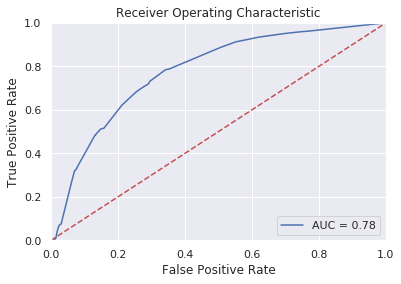

In [193]:
plt.figure(figsize=(6,4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


**Top 10 important features**

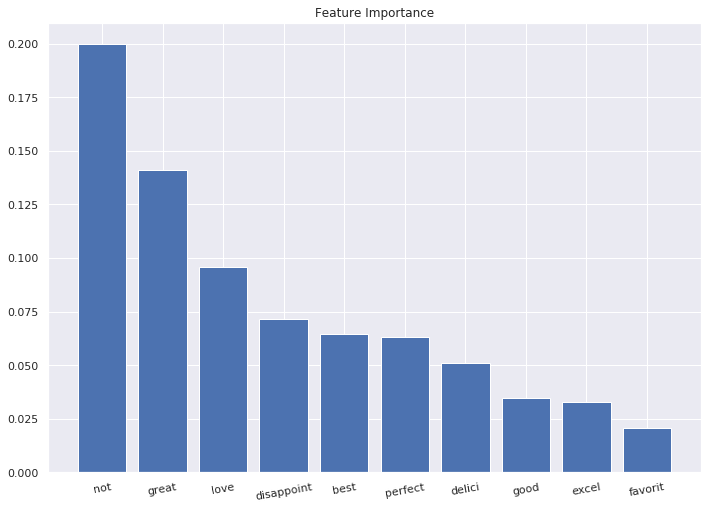

In [194]:
# print('top 10 features for -ve class: \n', df[1].sort_values(ascending=False)[:10])
tfidf_features=np.load('tfidf_feature_names.npy')
d = dict(zip(tfidf_features, w_tfidf))
# Sort feature importances in descending order
indices = np.argsort(w_tfidf)[::-1][:10]

# Rearrange feature names so they match the sorted feature importances
# names = uni_gram.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(10), w_tfidf[indices])

# Add feature names as x-axis labels
names = np.array(tfidf_features)
plt.xticks(range(10), names[indices], rotation=10)

# Show plot
plt.show()
# uni_gram.get_feature_names()

In [195]:
names[indices]

array(['not', 'great', 'love', 'disappoint', 'best', 'perfect', 'delici',
       'good', 'excel', 'favorit'], dtype='<U71')

**Graphviz Visualization**

In [197]:
import graphviz
dot_data = tree.export_graphviz(model_tfidf, out_file=None, feature_names=bow_features) 
graph = graphviz.Source(dot_data) 
graph.render("tree_representation_tfidf")

'tree_representation_tfidf.pdf'

## Avg Word2Vec

In [198]:
depths=[1,5,10,50,100,500,1000]
min_samples=[2,5,10,15,100,500,1000]
parameters=dict(max_depth=depths,min_samples_split=min_samples)
clf=RandomizedSearchCV(tree.DecisionTreeClassifier(),parameters, scoring='roc_auc', refit=True, cv=3,return_train_score=True)

clf.fit(x_train_w2v_av, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=None,
                                                    splitter='best')

In [0]:
cv_error=clf.cv_results_['mean_test_score']
train_error=clf.cv_results_['mean_train_score']
pred=clf.predict(x_train_w2v_av)
score=roc_auc_score(y_train, pred)
split=clf.best_params_['min_samples_split']
depth=clf.best_params_['max_depth']

In [200]:
print("Auc Score: ", score)
print("Best min_samples_split:", split,' ', "Best max_depth:", depth)

Auc Score:  0.745332674916598
Best min_samples_split: 100   Best max_depth: 5


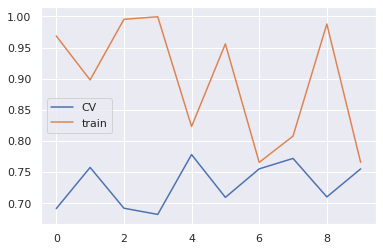

In [202]:
plt.figure(figsize=(6,4))
plt.plot(cv_error, label='CV')
plt.plot(train_error, label='train')
plt.legend()
plt.show()

In [203]:
model_w2v_av=tree.DecisionTreeClassifier(max_depth=depth, min_samples_split=split)
model_w2v_av.fit(x_train_w2v_av, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [204]:
y_pred_w2v_av = model_w2v_av.predict(x_test_w2v_av)
print("Test accuracy:", accuracy_score(y_test, y_pred_w2v_av))

Test accuracy: 0.72


In [0]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_w2v_av)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [206]:
df_cm

,negative,positive
negative,961,267
positive,433,839


In [207]:

# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_w2v_av))

              precision    recall  f1-score   support

         0.0       0.69      0.78      0.73      1228
         1.0       0.76      0.66      0.71      1272

    accuracy                           0.72      2500
   macro avg       0.72      0.72      0.72      2500
weighted avg       0.72      0.72      0.72      2500



In [0]:
y_conf_w2v_av = model_w2v_av.predict_proba(x_test_w2v_av)[:,1]
fpr, tpr, threshold = roc_curve(y_test,y_conf_w2v_av,pos_label=1)

In [209]:
roc_auc = auc(fpr, tpr)
roc_auc

0.7947677872697847

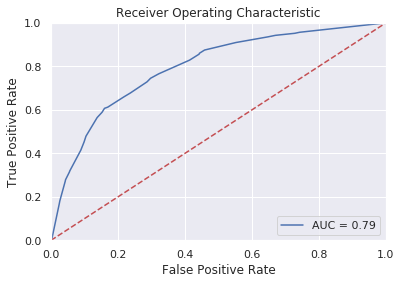

In [211]:
plt.figure(figsize=(6,4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## Tf-Idf weighted Word2Vec

In [212]:
depths=[1,5,10,50,100,500,1000]
min_samples=[2,5,10,15,100,500,1000]
parameters=dict(max_depth=depths,min_samples_split=min_samples)
clf=RandomizedSearchCV(tree.DecisionTreeClassifier(),parameters, scoring='roc_auc', refit=True, cv=3,return_train_score=True)

clf.fit(x_train_w2v_tf, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=None,
                                                    splitter='best')

In [0]:
cv_error=clf.cv_results_['mean_test_score']
train_error=clf.cv_results_['mean_train_score']
pred=clf.predict(x_train_w2v_tf)
score=roc_auc_score(y_train, pred)
split=clf.best_params_['min_samples_split']
depth=clf.best_params_['max_depth']

In [217]:
print("Auc Score: ", score)
print("Best min_samples_split:", split,' ', "Best max_depth:", depth)

Auc Score:  0.6952098475780428
Best min_samples_split: 500   Best max_depth: 100


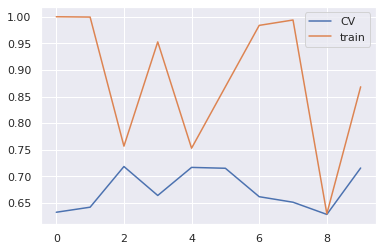

In [218]:
plt.figure(figsize=(6,4))
plt.plot(cv_error, label='CV')
plt.plot(train_error, label='train')
plt.legend()
plt.show()

In [219]:
model_w2v_tf=tree.DecisionTreeClassifier(max_depth=depth, min_samples_split=split)
model_w2v_tf.fit(x_train_w2v_tf, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=100,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [220]:
y_pred_w2v_tf = model_w2v_tf.predict(x_test_w2v_tf)
print("Test accuracy:", accuracy_score(y_test, y_pred_w2v_tf))

Test accuracy: 0.6856


In [0]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_w2v_tf)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [222]:
df_cm

,negative,positive
negative,831,397
positive,389,883


In [223]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_w2v_tf))

              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68      1228
         1.0       0.69      0.69      0.69      1272

    accuracy                           0.69      2500
   macro avg       0.69      0.69      0.69      2500
weighted avg       0.69      0.69      0.69      2500



In [0]:
y_conf_w2v_tf = model_w2v_tf.predict_proba(x_test_w2v_tf)[:,1]
fpr, tpr, threshold = roc_curve(y_test,y_conf_w2v_tf,pos_label=1)

In [225]:
roc_auc = auc(fpr, tpr)
roc_auc

0.7403416482289555

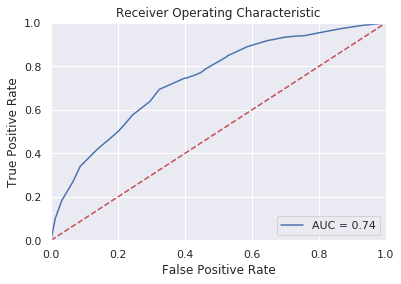

In [226]:
plt.figure(figsize=(6,4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
